In [14]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
import scipy.ndimage as ndimage
from scipy.spatial import distance
import time
import platform

from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import Create_Datasets

logging.basicConfig(format='%(message)s',level=logging.INFO)

channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transformVar = {"Test": transforms.Compose([
    transforms.Resize(128),    #Already 184 x 184
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     normalize
]),
    "Train": transforms.Compose([
    transforms.Resize(128),  # Already 184 x 184
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#     normalize
    ])
}

### COMMON FUNCTIONS TRAIN/VAL/TEST
def initial_input(model, image_series, starting_point, num_input_frames, channels, device, training):
    n = 0
    input_frames = image_series[:, (starting_point + n) * channels:(starting_point + n + num_input_frames) * channels, :, :].to(device)
    output_frames = model(input_frames, training=training)
    index = starting_point + n + num_input_frames
    target = image_series[:, index * channels:(index + 1) * channels, :, :].to(device)
    return output_frames, target

def new_input(model, image_series, starting_point, num_input_frames, num_output_frames, output_frames, target, channels, device, training):
    output_frames = torch.cat((output_frames, model(output_frames[:, -num_input_frames * channels:, :, :].clone(), mode="new_input", training=training)), dim=1)
    index = starting_point + num_output_frames + num_input_frames
    target = torch.cat((target, image_series[:, index * channels:(index + 1) * channels, :, :].to(device)), dim=1)
    return output_frames, target

def consequent_propagation(model, image_series, starting_point, n, output_frames, target, channels, device, training):
    output_frames = torch.cat((output_frames, model(torch.Tensor([0]), mode="internal", training=training)), dim=1)
    index = starting_point + n + num_input_frames
    target = torch.cat((target, image_series[:, index*channels:(index + 1) * channels, :, :].to(device)), dim=1)
    return output_frames, target

def plot_predictions():
    if (i == 0) & (batch_num == 0):
        predicted = output_frames[i, -channels:, :, :].cpu().detach()
        des_target = target[i, -channels:, :, :].cpu().detach()
        fig = plt.figure()
        pred = fig.add_subplot(1, 2, 1)
        imshow(predicted, title="Predicted smoothened %02d" % n, smoothen=True, obj=pred)
        tar = fig.add_subplot(1, 2, 2)
        imshow(des_target, title="Target %02d" % n, obj=tar)
        plt.show()


def train_epoch(model, epoch, train_dataloader, val_dataloader, num_input_frames, num_output_frames, channels, device, plot=False,):
    """
    Training of the network
    :param train: Training data
    :param val_dataloader: Validation data
    :return:
    """
    training = True
    model.train()           # initialises training stage/functions
    mean_loss = 0
    logging.info('Training: Ready to load batches')
    for batch_num, batch in enumerate(train_dataloader):
        batch_start = time.time()
        # logging.info('Batch: %d loaded in %.3f' %(batch_num, batch_time))
        mean_batch_loss = 0
        random_starting_points = random.sample(range(100 - num_input_frames - (2 * num_output_frames) - 1), 10)
        image_series = batch["image"]
        for i, starting_point in enumerate(random_starting_points):
            model.reset_hidden(batch_size=image_series.size()[0], training=True)
            lr_scheduler.optimizer.zero_grad()
            for n in range(2 * num_output_frames):
                if n == 0:
                    output_frames, target = initial_input(model, image_series, starting_point, num_input_frames, channels, device, training=training)
                elif n == num_output_frames:
                    output_frames, target = new_input(model, image_series, starting_point, num_input_frames, num_output_frames, output_frames, target, channels, device, training=training)
                else:
                    output_frames, target = consequent_propagation(model, image_series, starting_point, n, output_frames, target, channels, device, training=training)
                if plot:
                    plot_predictions()
            loss = F.mse_loss(output_frames, target)
            loss.backward()
            lr_scheduler.optimizer.step()

            mean_batch_loss += loss.item()
        analyser.save_loss_batchwise(mean_batch_loss / (i + 1), batch_increment=1)
        mean_loss += loss.item()

        batch_time = time.time() - batch_start
        logging.info("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime {:.2f}".format(epoch, batch_num + 1,
                   len(train_dataloader), 100. * (batch_num + 1) / len(train_dataloader), loss.item(), batch_time ) )        
        
    analyser.save_loss(mean_loss / (batch_num + 1), 1)
    val_start = time.time()
    validation_loss = validate(model, val_dataloader, num_input_frames, num_output_frames, channels, device, plot=False)
    analyser.save_validation_loss(validation_loss, 1)
    val_time = time.time() - val_start
    logging.info('Validation loss: %.6f\tTime: %.3f' % (validation_loss, val_time))



def validate(model, val_dataloader, num_input_frames, num_output_frames, channels, device, plot=False):
    """
    Validation of network (same protocol as training)
    :param val_dataloader: Data to test
    :param plot: If to plot predictions
    :return:
    """
    training = False
    model.eval()
    overall_loss = 0
    for batch_num, batch in enumerate(val_dataloader):
        random_starting_points = random.sample(range(100 - num_input_frames - (2 * num_output_frames) - 1), 10)
        image_series = batch["image"]
        batch_loss = 0
        for i, starting_point in enumerate(random_starting_points):
            model.reset_hidden(batch_size=image_series.size()[0], training=False)
            for n in range(2 * num_output_frames):
                if n == 0:
                    output_frames, target = initial_input(model, image_series, starting_point, num_input_frames, channels, device, training=training)
                elif n == num_output_frames:
                    output_frames, target = new_input(model, image_series, starting_point, num_input_frames, num_output_frames, output_frames, target, channels, device, training=training)
                else:
                    output_frames, target = consequent_propagation(model, image_series, starting_point, n, output_frames, target, channels, device, training=training)
                if plot:
                    plot_predictions()
            batch_loss += F.mse_loss(output_frames, target).item()
        overall_loss += batch_loss / (i + 1)
    val_loss = overall_loss / (batch_num + 1)
    return val_loss

# get_ipython().system('rm -rf Results/')
# get_ipython().system('rm Video_Data/.DS_Store')

nr_net = 0 

version = nr_net + 10
num_input_frames = 5
num_output_frames = 10
network_type = "7_kernel_3LSTM"

# Little trick to adjust path files for compatibility (I have a backup of the Main.py in case it doesn't work)
# stef_path = "/media/sg6513/DATADRIVE2/MSc/Wavebox/"
# if os.path.isfile(stef_path + "stefpc.txt"):
#     if not os.path.isdir(stef_path + "Results"):
#         os.mkdir(stef_path + "Results")
#     results_dir = stef_path + "Results/Simulation_Result_" + network_type + "_v%03d/" % version
#     maindir2 = stef_path
#     version += 200
# else:


if 'Darwin' in platform.system():
    data_dir = './'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("./Results"):
    os.mkdir("./Results")
results_dir = "./Results/Simulation_Result_" + network_type + "_v%03d/" % version

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)


# Data
filename_data = results_dir + "all_data_" + "_v%03d.pickle" % version
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = Create_Datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)


# analyser
filename_analyser = results_dir + network_type + "_analyser_v%03d.pickle" % version
if os.path.isfile(filename_analyser):
    logging.info('Loading analyser')
    analyser = load(filename_analyser)
else:
    logging.info('Creating analyser')
    analyser = Analyser(results_dir)

# Model
filename_model = results_dir + network_type + "_model_v%03d.pt" % version
if os.path.isfile(filename_model):
    model = torch.load(filename_model)
else:
    model = Network(device, channels)

# Learning Rate scheduler w. optimizer
# Optimizer
optimizer_algorithm = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# Add learning rate schedulers
# Decay LR by a factor of gamma every step_size epochs
scheduler_type = 'plateau'
if scheduler_type == 'step':
    gamma = 0.5
    step_size = 40
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer_algorithm, step_size=step_size, gamma=gamma)
elif scheduler_type == 'plateau':
    # Reduce learning rate when a metric has stopped improving
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_algorithm, mode='min', factor=0.1, patience=7)

filename_metadata = results_dir + network_type + "_metadata_v%03d.pickle" % version
meta_data_dict = {  "optimizer": optimizer_algorithm.state_dict(),
                    "scheduler_type": scheduler_type, 
                    "scheduler": lr_scheduler.state_dict()}
save(meta_data_dict, filename_metadata)


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

root_dir = train_dataset.root_dir
img_path = train_dataset.imagesets[0]
im_list = sorted(listdir(root_dir + img_path[1]))

model.to(device)

logging.info('Experiment %d' % version)
logging.info('Start training')
epochs=0
# for epoch in range(epochs):
#     epoch_start = time.time()

#     logging.info('Epoch %d' % epoch)
#     train_epoch(model, epoch, train_dataloader, val_dataloader, num_input_frames, num_output_frames, channels, device, plot=False)
#     """
#     Here we can access analyser.validation_loss to make decisions
#     """
#     # Learning rate scheduler
#     # perform scheduler step if independent from validation loss
#     if scheduler_type == 'step':
#         lr_scheduler.step()
#     # perform scheduler step if Dependent on validation loss
#     if scheduler_type == 'plateau':
#         validation_loss = analyser.validation_loss[-1]
#         lr_scheduler.step(validation_loss)
#     save_network(model, filename_model)
#     save(analyser, filename_analyser)

#     epoch_time = time.time() - epoch_start 
#     logging.info('Epoch time: %.1f' % epoch_time)

# analyser = []
# model =[]
# lr_scheduler = []
# scheduler_dict = []

# analyser.plot_loss()
# analyser.plot_accuracy()
# analyser.plot_loss_batchwise()
# analyser.plot_validation_loss()

Loading datasets
Creating analyser
Experiment 10
Start training


In [21]:
epoch=1
plot=False
# def train_epoch(model, epoch, train_dataloader, val_dataloader, num_input_frames, num_output_frames, channels, device, plot=False,):
training = True
model.train()           # initialises training stage/functions
mean_loss = 0
logging.info('Training: Ready to load batches')
for batch_num, batch in enumerate(train_dataloader):
    batch_start = time.time()
    # logging.info('Batch: %d loaded in %.3f' %(batch_num, batch_time))
    mean_batch_loss = 0
    random_starting_points = random.sample(range(100 - num_input_frames - (2 * num_output_frames) - 1), 10)
    image_series = batch["image"]
    for i, starting_point in enumerate(random_starting_points):
        model.reset_hidden(batch_size=image_series.size()[0], training=True)
        lr_scheduler.optimizer.zero_grad()
        for n in range(2 * num_output_frames):
            if n == 0:
                output_frames, target = initial_input(model, image_series, starting_point, num_input_frames, channels, device, training=training)
            elif n == num_output_frames:
                output_frames, target = new_input(model, image_series, starting_point, num_input_frames, num_output_frames, output_frames, target, channels, device, training=training)
            else:
                output_frames, target = consequent_propagation(model, image_series, starting_point, n, output_frames, target, channels, device, training=training)
            if plot:
                plot_predictions()
        loss = F.mse_loss(output_frames, target)
        loss.backward()
        lr_scheduler.optimizer.step()
        mean_batch_loss += loss.item()
        break
        
    analyser.save_loss_batchwise(mean_batch_loss / (i + 1), batch_increment=1)
    mean_loss += loss.item()

    batch_time = time.time() - batch_start
    logging.info("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime {:.2f}".format(epoch, batch_num + 1,
               len(train_dataloader), 100. * (batch_num + 1) / len(train_dataloader), loss.item(), batch_time ) )        

    if batch_num > 3:
        print('break')
        break
        
analyser.save_loss(mean_loss / (batch_num + 1), 1)
# val_start = time.time()
# validation_loss = validate(model, val_dataloader, num_input_frames, num_output_frames, channels, device, plot=False)
# analyser.save_validation_loss(validation_loss, 1)
# val_time = time.time() - val_start
# logging.info('Validation loss: %.6f\tTime: %.3f' % (validation_loss, val_time))

Training: Ready to load batches
Train Epoch: 1 [1/144 (1%)]	Loss: 0.663284	Time 29.09
Train Epoch: 1 [2/144 (1%)]	Loss: 0.660408	Time 13.36
Train Epoch: 1 [3/144 (2%)]	Loss: 0.668999	Time 11.84
Train Epoch: 1 [4/144 (3%)]	Loss: 0.624146	Time 11.22
Train Epoch: 1 [5/144 (3%)]	Loss: 0.613687	Time 11.16


break


Train Epoch: 1 [6/144 (4%)]	Loss: 0.624366	Time 12.81


break


Train Epoch: 1 [7/144 (5%)]	Loss: 0.616431	Time 12.20


break


Train Epoch: 1 [8/144 (6%)]	Loss: 0.609914	Time 11.82


break


Train Epoch: 1 [9/144 (6%)]	Loss: 0.608128	Time 11.70


break


Train Epoch: 1 [10/144 (7%)]	Loss: 0.596807	Time 11.68


break


Train Epoch: 1 [11/144 (8%)]	Loss: 0.544661	Time 10.69


break


Train Epoch: 1 [12/144 (8%)]	Loss: 0.541056	Time 11.00


break


Train Epoch: 1 [13/144 (9%)]	Loss: 0.543576	Time 11.29


break


Train Epoch: 1 [14/144 (10%)]	Loss: 0.547027	Time 11.27


break


Train Epoch: 1 [15/144 (10%)]	Loss: 0.520086	Time 10.88


break


Train Epoch: 1 [16/144 (11%)]	Loss: 0.535251	Time 12.91


break


Train Epoch: 1 [17/144 (12%)]	Loss: 0.510006	Time 11.20


break


Train Epoch: 1 [18/144 (12%)]	Loss: 0.511077	Time 10.69


break


Train Epoch: 1 [19/144 (13%)]	Loss: 0.494028	Time 10.94


break


Train Epoch: 1 [20/144 (14%)]	Loss: 0.491988	Time 10.62


break


Train Epoch: 1 [21/144 (15%)]	Loss: 0.471085	Time 11.18


break


Train Epoch: 1 [22/144 (15%)]	Loss: 0.480037	Time 11.04


break


Train Epoch: 1 [23/144 (16%)]	Loss: 0.486340	Time 11.09


break


Train Epoch: 1 [24/144 (17%)]	Loss: 0.447304	Time 10.59


break


Train Epoch: 1 [25/144 (17%)]	Loss: 0.439576	Time 11.25


break


Train Epoch: 1 [26/144 (18%)]	Loss: 0.447083	Time 11.35


break


Train Epoch: 1 [27/144 (19%)]	Loss: 0.436873	Time 11.20


break


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/stathis/anaco

KeyboardInterrupt: 

NameError: name 'Type_Network' is not defined

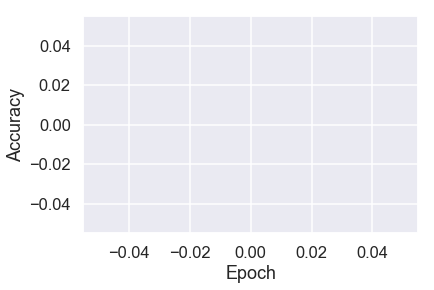

In [22]:
analyser.plot_accuracy()